# Лабораторная работа 2
«Наивный байесовский» классификатор.

### Скачиваем пакеты

In [ ]:
%pip install scikit-learn
%pip install numpy
%pip install pandas
%pip install seaborn

### Импортируем пакеты

In [223]:
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

### Убираем предупреждения

In [4]:
warnings.filterwarnings('ignore')

## Часть 1
Загрузить таблицу Mushroom из репозитория UCI (любого источника) в объект DataFrame.
Вычислить распределение значений категориальных признаков по классам (использовать pd.groupby).
Визуализировать распределения.


### Загружаем таблицу Mushroom в объект DataFrame

In [224]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"

# Заголовки признаков
# "poisonous" = target
headers = ["poisonous", "cap-shape", "cap-surface", "cap-color", "bruises", "odor", "gill-attachment",
           "gill-spacing", "gill-size", "gill-color", "stalk-shape", "stalk-root", "stalk-surface-above-ring",
           "stalk-surface-below-ring", "stalk-color-above-ring", "stalk-color-below-ring", "veil-type",
           "veil-color", "ring-number", "ring-type", "spore-print-color", "population", "habitat"]

data = pd.read_csv(url, names=headers)
data.head()

,poisonous,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### Вычисляем распределение значений категориальных признаков по классам и визуализируем их

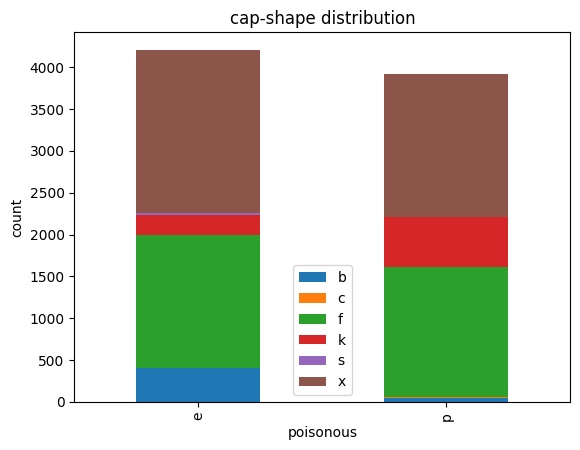

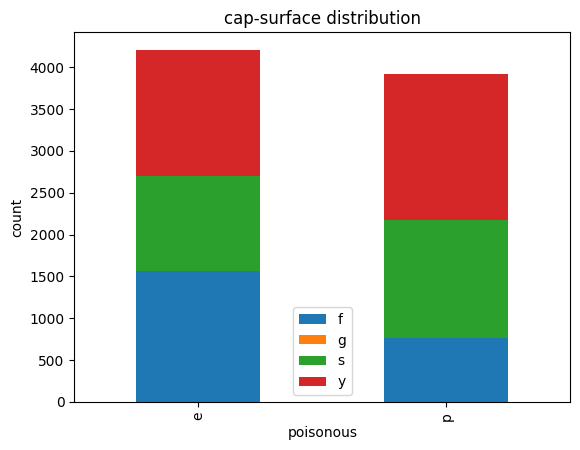

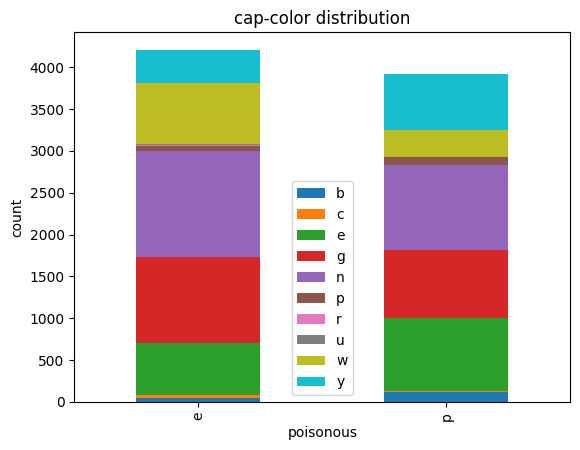

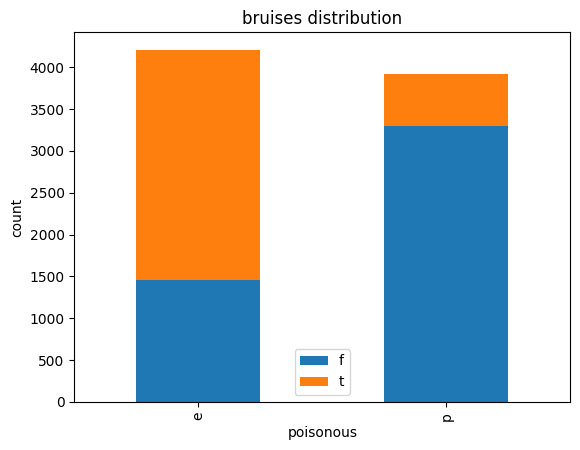

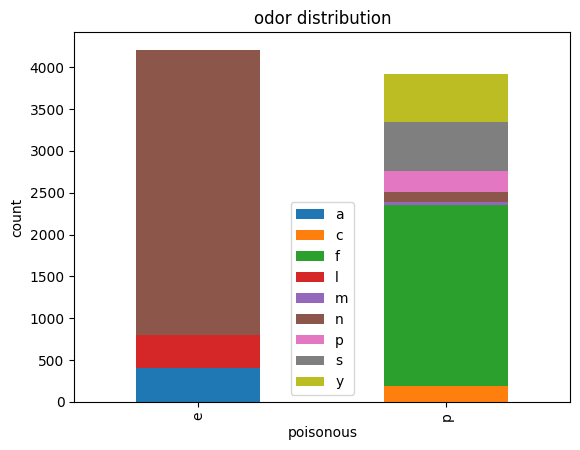

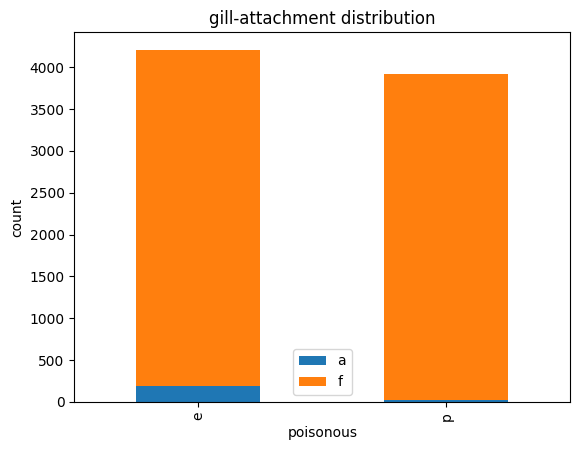

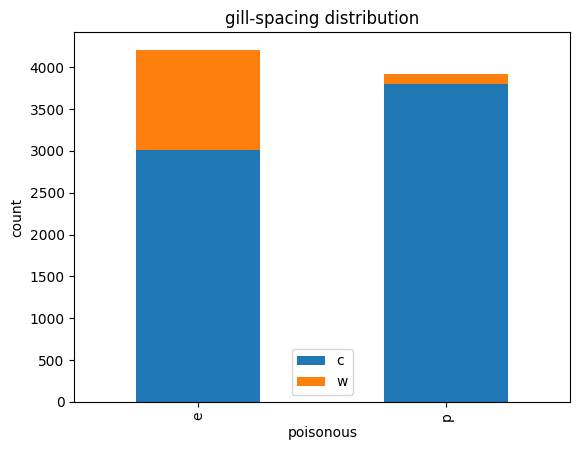

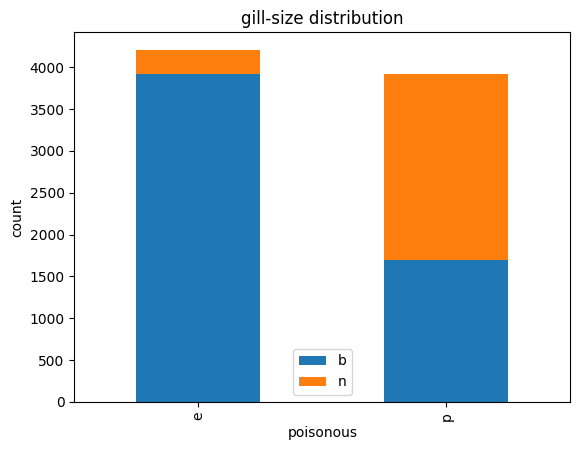

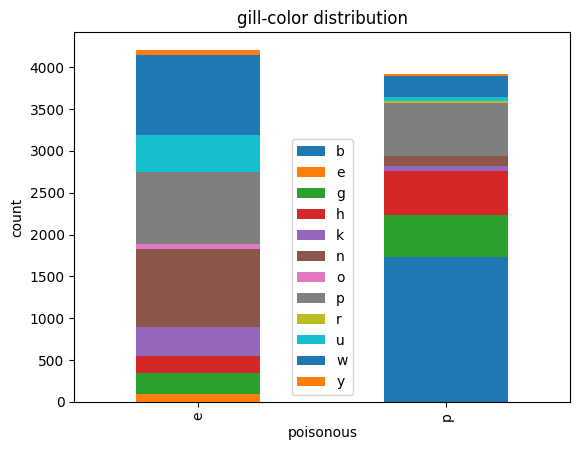

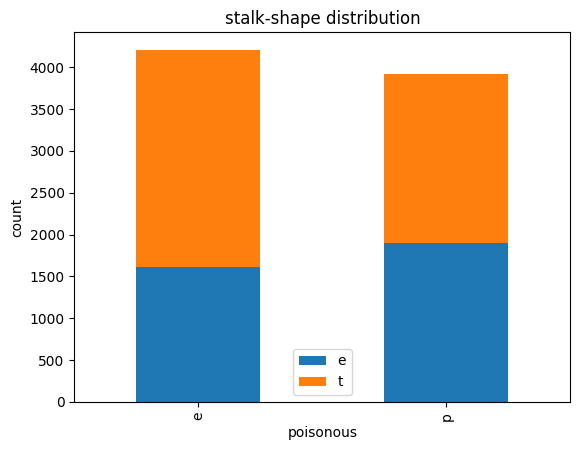

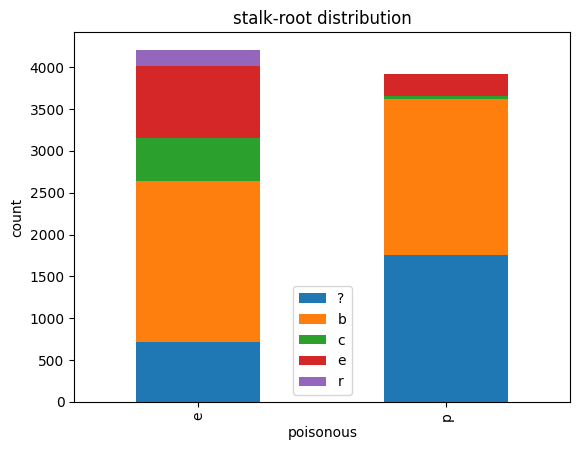

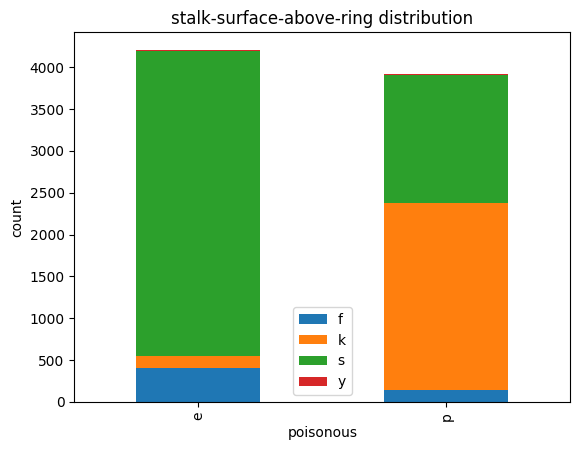

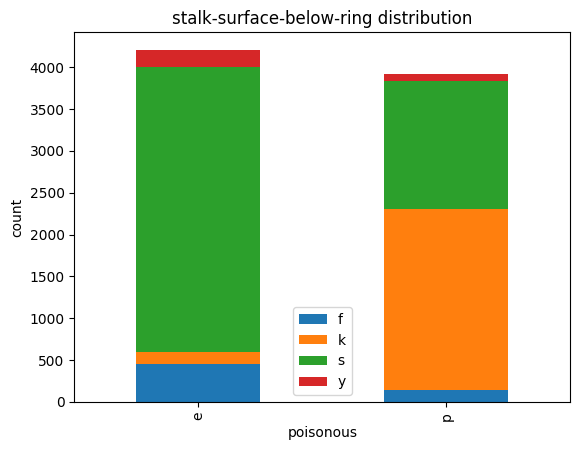

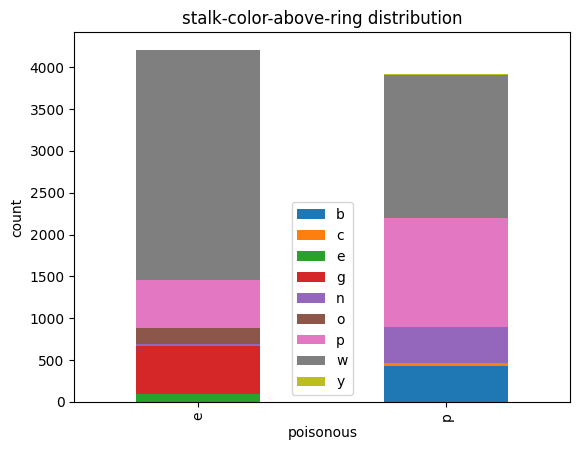

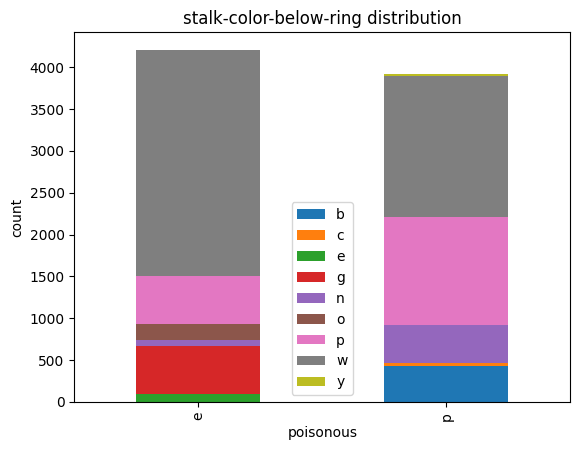

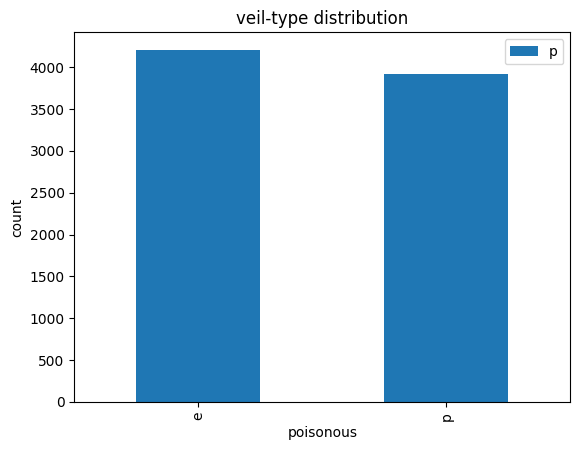

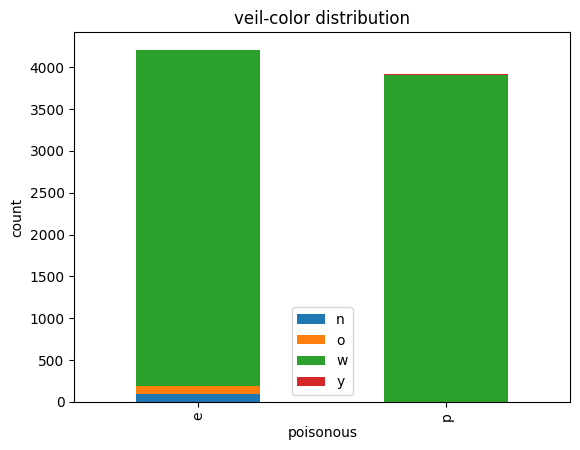

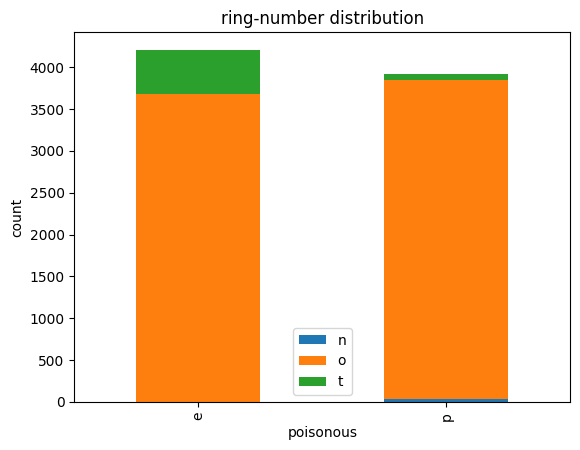

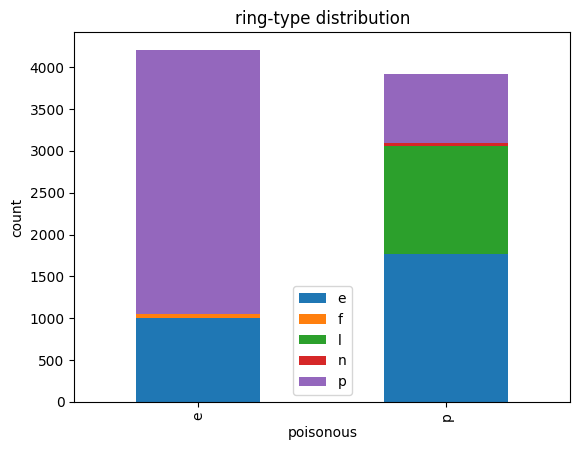

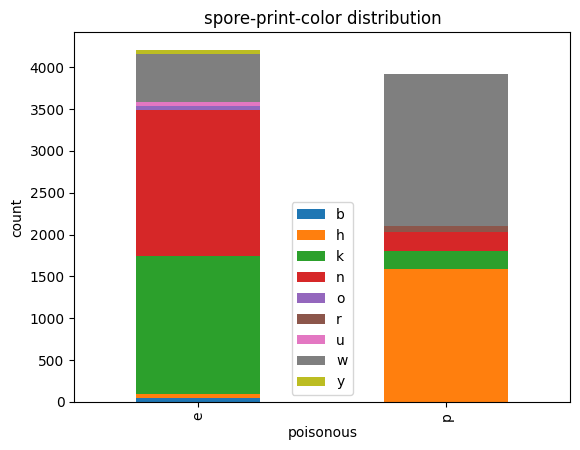

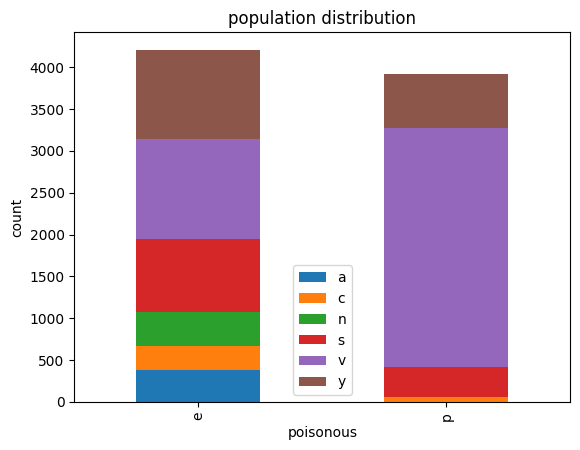

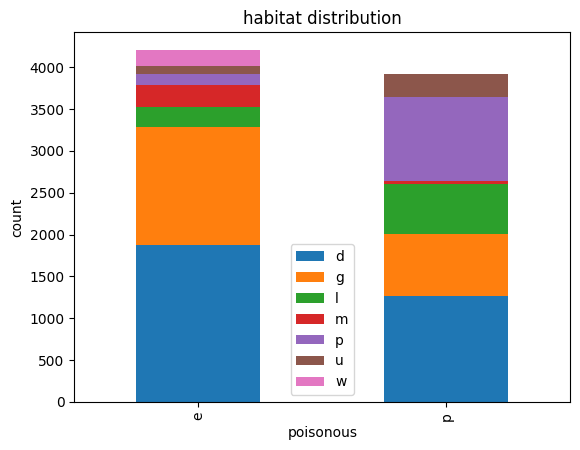

In [225]:
for feature in data.columns[1:]:
    plot = data.groupby(['poisonous', feature]).agg(count=(feature, 'count')).unstack().fillna(0).plot(
        kind='bar', stacked=True, legend=False, title=feature + " distribution", ylabel="count"
        )
    
    # Модифицируем легенду, чтобы всё по красоте было
    labels = plot.get_legend_handles_labels()[1]
    new_legend = list(map(lambda x: x[-2:-1], labels))
    plot.legend(new_legend)

## Часть 2
Построить решающую функцию по каждой переменной на основе частот. Вычислить точность каждого решения (на той же обучающей выборке). Найти наиболее информативную переменную (с минимальным числом ошибок).

### Accuracy, precision, recall

**Accuracy** - доля правильных ответов алгоритма.

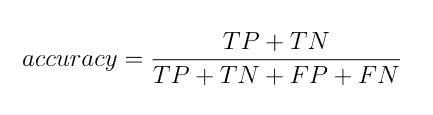

**Precision** - доля объектов, названных классификатором положительными и при этом действительно являющимиеся положительными. Деменострирует способность отличать этот класс от других классов.

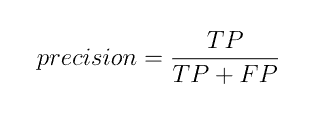

**Recall** - доля объектов положительного класса из всех объектов положительного класса. Демонстрирует способность алгоритма обнаруживать данный класс вообще.

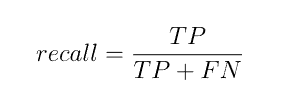

### Решение

In [226]:
# Создание решающей функции на основе частот для определённой переменной
# (для каждого значения признака считаем количество p и e)
def create_decision_function(data, variable):
    decision_function = {}
    for value in data[variable].unique(): # Проходимся по всем значениям признака
        subdata = data[data[variable] == value] # Записи, у которых в столбце variable стоит значение value
        counts = subdata['poisonous'].value_counts() # Считаем распределение значения признака по классам poisonous
        if "e" in counts:
            e_count = counts["e"]
        else:
            e_count = 0
        if "p" in counts:
            p_count = counts["p"]
        else:
            p_count = 0
        decision_function[value] = {"e": e_count, "p": p_count}
    return decision_function

# Оценка accuracy решающей функции
def decision_function_accuracy(data, variable, decision_function):
    correct = 0
    for index, value in enumerate(data[variable]): # каждому значению приписываем индекс
        if decision_function[value]["e"] >= decision_function[value]["p"]:
            prediction = "e"
        else:
            prediction = "p"
        if prediction == data['poisonous'][index]: # сравниваем предсказанный результат с действительным
            correct += 1
    accuracy = correct / len(data)
    return accuracy

# Находим наиболее информативную переменную
variables = data.columns[1:]
best_variable = None
best_accuracy = 0
for variable in variables:
    decision_function = create_decision_function(data, variable)
    accuracy = decision_function_accuracy(data, variable, decision_function)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_variable = variable

print(f"Наиболее информативаня переменная - '{best_variable}', accuracy = {best_accuracy}")

Наиболее информативаня переменная - 'odor', accuracy = 0.9852289512555391


## Часть 3
Построить «наивный» байесовский классификатор из sklearn. Оценить точность.

### Байесовская теорема


**Байесовская теорема (или формула Байеса)** - это теорема из теории вероятностей, которая позволяет обновлять вероятности событий на основе новой информации.

$$ P(A∣B)= \frac{P(B∣A)⋅P(A)} {P(B)} $$

$ P(A∣B) $ - это условная вероятность события A при условии, что произошло событие B.

$ P(B∣A) $ - это условная вероятность события B при условии, что произошло событие A.

$ P(A) $ - это априорная вероятность события A (вероятность A до получения новой информации).

$ P(B) $ - это вероятность события B (общая вероятность события B).

### Наивный байесовский классификатор

**Наивный байесовский классификатор (Naive Bayes classifier)** - это простой вероятностный классификатор, основанный на байесовской теореме с предположением о наивной независимости признаков.

Наивный байесовский классификатор называется "наивным" из-за предположения о независимости признаков. Это означает, что классификатор считает, что каждый признак независим от остальных при заданном классе. В реальности признаки могут быть коррелированы, и это предположение не всегда соблюдается.

Алгоритм работы классификатора:
1. **Обучение:** На этом этапе алгоритм анализирует обучающие данные и строит модель, которая описывает статистические зависимости между признаками и классами.
    
    1. Вычисление априорных вероятностей классов. Это вероятности появления каждого класса в обучающем наборе данных.
    
    2. Вычисление условных вероятностей признаков при условии каждого класса. Это вероятности появления конкретных значений признаков для каждого класса.

2. **Классификация:** После обучения алгоритм принимает новые данные (тестовые данные) и оценивает вероятности принадлежности к каждому классу на основе ранее вычисленных вероятностей.

    1. Вычисление апостериорных вероятностей классов для новых данных. Это вероятности появления каждого класса после учета данных.
    
    2. Выбор класса с наибольшей апостериорной вероятностью как предсказанного класса для тестовых данных.

### Решение

In [227]:
# Кодируем значения признаков числами
encoded_data = data.copy()
label_encoder = LabelEncoder()
for column in encoded_data.columns:
    encoded_data[column] = label_encoder.fit_transform(encoded_data[column])

# Разделение данных на обучающий и тестовый набор
X = encoded_data.drop('poisonous', axis=1) # features
y = encoded_data['poisonous']              # target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Построение "наивного" байесовского классификатора
nb_classifier = CategoricalNB()
nb_classifier.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = nb_classifier.predict(X_test)

# Оценка точности классификатора
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность \"наивного\" байесовского классификатора: {accuracy}")

Точность "наивного" байесовского классификатора: 0.9507692307692308


## Часть 4
Самостоятельно реализовать метод, не используя готовый. Сравнить полученное решение с библиотечным. Добавить регуляризатор в оценки частот.

In [230]:
encoded_data = data.copy()

# Кодирование категориальных признаков, представляем все значения призаков в виде отдельных столбцов
encoded_data = pd.get_dummies(encoded_data, columns=encoded_data.columns[1:], drop_first=True)

# Разделение данных на обучающий и тестовый набор
np.random.seed(137)                          # при некоторых сидах точности классификаторов (своего и библиотечного) равны
encoded_data = encoded_data.sample(frac=1)  # перемешиваем данные
train_size = int(0.8 * len(encoded_data))
train_data = encoded_data[:train_size]
test_data = encoded_data[train_size:]

# Разделяем данные на классы
edible_data = train_data[train_data['poisonous'] == 'e']
poisonous_data = train_data[train_data['poisonous'] == 'p']

# Вычисляем априорные вероятности
prior_edible = len(edible_data) / len(train_data)
prior_poisonous = len(poisonous_data) / len(train_data)

# Вычисляем условные вероятности сглаживанием (Laplace сглаживание)
alpha = 1  # параметр сглаживания
n_features = len(train_data.columns) - 1
conditional_edible = (edible_data.drop('poisonous', axis=1).sum() + alpha) / (len(edible_data) + alpha * n_features)
conditional_poisonous = (poisonous_data.drop('poisonous', axis=1).sum() + alpha) / (len(poisonous_data) + alpha * n_features)

# Функция для классификации
def classify_mushroom(row):
    features = row[1:]
    
    # Вычисляем вероятности для каждого класса
    prob_edible = prior_edible
    prob_poisonous = prior_poisonous
    
    for feature, value in features.items():
        prob_edible *= conditional_edible[feature] if value == 1 else (1 - conditional_edible[feature])
        prob_poisonous *= conditional_poisonous[feature] if value == 1 else (1 - conditional_poisonous[feature])
    
    # Классификация
    if prob_edible > prob_poisonous:
        return 'e'
    else:
        return 'p'
    
# Классификация на тестовом наборе
predicted = test_data.apply(classify_mushroom, axis=1)

# Оценка точности классификатора
accuracy = (predicted == test_data['poisonous']).mean()
print(f"Точность собственной реализации:                    {accuracy}")

# Классификация с помощью библиотечного классфикатора на тех же данных

# Разделение данных на обучающий и тестовый набор
X_train = train_data.drop('poisonous', axis=1)
y_train = train_data['poisonous']
X_test = test_data.drop('poisonous', axis=1)
y_test = test_data['poisonous']

# Построение "наивного" байесовского классификатора
nb_classifier = CategoricalNB()
nb_classifier.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = nb_classifier.predict(X_test)

# Оценка точности классификатора
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность библиотечного байесовского классификатора: {accuracy}")

Точность собственной реализации:                    0.9452307692307692
Точность библиотечного байесовского классификатора: 0.9458461538461539


## Часть 5
Применить метод логистической регрессии, использовав в качестве переменных оценки вероятностей, подвергнутые обратному логистическому преобразованию.

### Основные идеи метода логистической регрессии:

1. *Логистическая функция*: Для оценки вероятности принадлежности наблюдения к классу используется логистическая функция, также называемая сигмоидой. Эта функция преобразует линейную комбинацию признаков в диапазон значений от 0 до 1.

2. *Линейная комбинация*: Метод логистической регрессии моделирует линейную комбинацию независимых переменных с использованием весов (коэффициентов) для каждого признака, плюс смещения (bias). Эта комбинация является входом для логистической функции.

3. *Обучение*: Цель обучения логистической регрессии - настроить параметры модели (веса и смещение) таким образом, чтобы минимизировать разницу между прогнозами модели и истинными значениями целевой переменной.

4. *Применение*: После обучения модель может использоваться для прогнозирования вероятности принадлежности новых наблюдений к классу. По умолчанию, если вероятность превышает 0,5, объект относится к положительному классу, иначе - к отрицательному классу.

### Обратное логистическое преобразование

**Обратное логистическое преобразование** - это процесс, который позволяет получить линейную комбинацию независимых переменных (признаков) на основе известных вероятностей, полученных с использованием логистической функции. Это полезно, если вы хотите получить оценку или предсказание исходных значений, когда у вас есть вероятности, полученные с помощью логистической регрессии. Обратное логистическое преобразование осуществляется с использованием логистической функции (сигмоиды) и обратной формулы.

Формула обратного логистического преобразования (инверсии сигмоиды) для одной вероятности $ p $ выглядит следующим образом:

$$ p= \frac {1} {1 + e ^ {-z}} $$

- $ p $ - вероятность, которую нужно обратно преобразовать.

- $ z $ - линейная комбинация независимых переменных (признаков) с весами и смещением в логистической регрессии.

Чтобы получить $ z $, можно переформулировать формулу следующим образом:

$$ z = \ln{\frac {p} {1-p}} $$

Эта формула позволяет получить линейную комбинацию признаков, которая соответствует заданной вероятности $ p $

### Решение

In [232]:
# Первым делом, нужно получить оценки вероятностей принадлежности к классам

encoded_data = data.copy()

label_encoder = LabelEncoder()
for column in encoded_data.columns:
    encoded_data[column] = label_encoder.fit_transform(encoded_data[column])

# Разделение данных на обучающий и тестовый набор
X = encoded_data.drop('poisonous', axis=1)
y = encoded_data['poisonous']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Построение "наивного" байесовского классификатора
nb_classifier = CategoricalNB()
nb_classifier.fit(X_train, y_train)

# Получаем оценки вероятностей
predictions = nb_classifier.predict_proba(X)

# Затем нужно применить обратное логистическое преобразование к оценкам вероятностей

# Функция обратного логистического преобразования
def inverse_logistic_transform(probability):
    if (probability == 1 or probability == 0):
        return probability
    
    return np.log(probability / (1 - probability))

# Таблица с оценками вероятностей
data_prob = pd.DataFrame()
data_prob['e'] = [inverse_logistic_transform(sub[0]) for sub in predictions]
data_prob['p'] = [inverse_logistic_transform(sub[1]) for sub in predictions]
data_prob['target'] = y

# Опять разделяем данные на обучающий и тестовый набор
X1 = data_prob.drop('target', axis=1)
y1 = data_prob['target']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Применяем метод логистической регрессии для полученных данных и смотрим на точность

# Построение модели логистической регрессии
logistic_model = sklearn.linear_model.LogisticRegression()
logistic_model.fit(X1_train, y1_train)

# Предсказание на тестовом наборе
y1_pred = logistic_model.predict(X1_test)

# Оценка точности
accuracy = accuracy_score(y1_test, y1_pred)
print(f"Точность логистической регрессии: {accuracy}")

Точность логистической регрессии: 0.9735384615384616
